# MNIST 手寫數字辨識使用卷積神經網絡(CNN)

![cnn](https://www.cntk.ai/jup/cntk103d_convonly2.png)

圖片出處:[CNTK_103D_MNIST_ConvolutionalNeuralNetwork](https://cntk.ai/pythondocs/CNTK_103C_MNIST_MultiLayerPerceptron.html)

## CNN 卷積神經網路簡介

### STEP1. 卷積神經網路介紹

CNN 卷積神經網路可以分成兩大部分:
* 影像的特徵提取: 透過 Convolution 與 Max Pooling 提取影像特徵.
* Fully connected Feedforward network: Flatten layers, hidden layers and output layers

![cnn](https://2.bp.blogspot.com/-lo4ANmafiQM/WVpEeo68VPI/AAAAAAAAWxE/7FJBUGp-GrQFL5fUYEg6tQAJWXUHrtgWgCLcBGAs/s1600/3812_1.png)

### STEP2. 卷積運算 (Convolution) 

卷積運算的原理是將一個影像透過卷積運算的 Filter weight(s) 產生多個影像, 在上面第一層的 Convolution 為例: 
1. 先以隨機方式產生 16 個 3x3 的 filter weight(s) 
2. 要轉換的影像由左而右, 由上而下透過 filter weight 產生新影像的值
3. 使用 16 個 filter weight 產生 16 個影像 

![convolution](https://4.bp.blogspot.com/-65gO4Ylb-pU/WVpEj04De1I/AAAAAAAAWxI/Y3wX2OYjzJYddDYCaH24-Swmhj7Q9U8iACLcBGAs/s1600/3591_1.PNG)

### STEP3. 池化運算 (Max-Pooling) 
Max-Pool 運算可以將影像縮減取樣 (downsampling), 如下圖: 原本影像是 4x4, 經過 Max-Pool 運算後, 影像大小為 2x2: 

![maxpool](https://4.bp.blogspot.com/-HCaeeLJ9PSI/WVpEpg-qWiI/AAAAAAAAWxM/v4Qg8BAHuxAaC9Eoe2JZWY8jdt_vyCy8gCLcBGAs/s1600/3591_2.PNG)

downsampling 有以下好處: 
* 減少需要處理的資料點: 減少後續運算所需時間.
* 讓影像位置的差異變小: 例如手寫數字 7, 位置上下左右可能不同, 但是位置不同可能影響辨識. 減少影像大小讓數字的位置差異變小.
* 參數的數量和計算量下降: 這在一定程度上也控制了 Overfitting 的狀況.

## 進行資料前處理 (Preprocess) 
CNN (Convolution Neural Network) 與 MLP 進行資料的前處理方式有所不同, 說明如下: 

* MLP : image reshape (60000, 784): MLP 因為直接送進神經元處理, 所以 60,000 筆的每一筆圖像(28x28)轉換為 784 個神經元輸入。
* CNN : image reshape (60000, 28, 28, 1): CNN 因為必須先進行卷積與池化 (Max-Pool) 運算, 所以必須保留影像的維度. 因此 60,000 筆的每一筆圖像(28x28)轉換成 28 (長) x 28(寬) x 1(圖像頻道) 的影像單位。

### STEP1. 資料讀取與轉換

In [2]:
from keras.datasets import mnist  
from keras.utils import np_utils  
import numpy as np

np.random.seed(10)  
  
# Read MNIST data  
(X_Train, y_Train), (X_Test, y_Test) = mnist.load_data()  
  
# Translation of data  
X_Train4D = X_Train.reshape(X_Train.shape[0], 28, 28, 1).astype('float32')  
X_Test4D = X_Test.reshape(X_Test.shape[0], 28, 28, 1).astype('float32')

### STEP2. 將 Features 進行標準化與 Label 的 Onehot encoding

In [3]:
# Standardize feature data  
X_Train4D_norm = X_Train4D / 255  
X_Test4D_norm = X_Test4D /255  
  
# Label Onehot-encoding  
y_TrainOneHot = np_utils.to_categorical(y_Train)
y_TestOneHot = np_utils.to_categorical(y_Test)

## 建立模型(卷積神經網絡 CNN)

接著會依照下面流程圖建立模型:

![cnn](https://4.bp.blogspot.com/-lo4ANmafiQM/WVpEeo68VPI/AAAAAAAAWxE/gVT33Q_dxqMxqZJfnbxS-fxl7ZdsntZcwCEwYBhgL/s1600/3812_1.png)

### STEP1. 建立卷積層與池化層

In [4]:
from keras.models import Sequential  
from keras.layers import Dense,Dropout,Flatten,Conv2D,MaxPool2D 

model = Sequential()  
# Create CN layer 1  
model.add(Conv2D(filters=16,  
                 kernel_size=(5,5),  
                 padding='same',  
                 input_shape=(28,28,1),  
                 activation='relu',
                 name='conv2d_1')) 
# Create Max-Pool 1  
model.add(MaxPool2D(pool_size=(2,2), name='max_pooling2d_1'))  
  
# Create CN layer 2  
model.add(Conv2D(filters=36,  
                 kernel_size=(5,5),  
                 padding='same',  
                 input_shape=(28,28,1),  
                 activation='relu',
                 name='conv2d_2'))  
  
# Create Max-Pool 2  
model.add(MaxPool2D(pool_size=(2,2), name='max_pooling2d_2'))  
  
# Add Dropout layer  
model.add(Dropout(0.25, name='dropout_1'))

### STEP2. 建立神經網路

#### 建立平坦層 
下面程式碼建立平坦層, 將之前步驟已經建立的池化層2, 共有 36 個 7x7 維度的影像轉換成 1 維向量, 長度是 36x7x7 = 1764, 也就是對應到 1764 個神經元: 

In [5]:
model.add(Flatten(name='flatten_1'))

#### 建立 Hidden layer

In [6]:
model.add(Dense(128, activation='relu', name='dense_1'))  
model.add(Dropout(0.5, name='dropout_2'))

#### 建立輸出層

最後建立輸出層, 共有 10 個神經元, 對應到 0~9 共 10 個數字. 並使用 softmax 激活函數 進行轉換 (softmax 函數可以將神經元的輸出轉換成每一個數字的機率):

In [7]:
model.add(Dense(10, activation='softmax', name='dense_2'))

### STEP3. 查看模型的摘要

In [8]:
model.summary()  
print("")  

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 28, 28, 16)        416       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 14, 36)        14436     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 7, 7, 36)          0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 7, 7, 36)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 1764)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               225920    
__________

![cnn](https://3.bp.blogspot.com/-fHmURvhoPGE/WVpEw-lv1HI/AAAAAAAAWxQ/oClbewBNDTc6YRL9iWbzL67ZwZ2FAWyygCLcBGAs/s1600/3591_3.PNG)

## 進行訓練
接著我們使用 Back Propagation 進行訓練。

### STEP1. 定義訓練並進行訓練

In [9]:
# 定義訓練方式  
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])  
  
# 開始訓練  
train_history = model.fit(x=X_Train4D_norm,  
                          y=y_TrainOneHot, validation_split=0.2,  
                          epochs=10, batch_size=300, verbose=1)

Train on 48000 samples, validate on 12000 samples
Epoch 1/10
48000/48000 [==============================] - 14s 287us/step - loss: 0.4897 - acc: 0.8475 - val_loss: 0.0961 - val_acc: 0.9729
Epoch 2/10
48000/48000 [==============================] - 7s 136us/step - loss: 0.1406 - acc: 0.9586 - val_loss: 0.0639 - val_acc: 0.9805
Epoch 3/10
48000/48000 [==============================] - 7s 136us/step - loss: 0.1022 - acc: 0.9693 - val_loss: 0.0509 - val_acc: 0.9839
Epoch 4/10
48000/48000 [==============================] - 7s 136us/step - loss: 0.0829 - acc: 0.9758 - val_loss: 0.0453 - val_acc: 0.9861
Epoch 5/10
48000/48000 [==============================] - 7s 136us/step - loss: 0.0712 - acc: 0.9783 - val_loss: 0.0399 - val_acc: 0.9879
Epoch 6/10
48000/48000 [==============================] - 7s 136us/step - loss: 0.0637 - acc: 0.9810 - val_loss: 0.0394 - val_acc: 0.9894
Epoch 7/10
48000/48000 [==============================] - 7s 137us/step - loss: 0.0561 - acc: 0.9827 - val_loss: 0.0450 -

在 compile 方法中: 
* loss: 設定 Loss Function, 這邊選定 Cross Entropy 作為 Loss Function.
* optimizer: 設定訓練時的優化方法, 在深度學習使用 adam (Adam: A Method for Stochastic Optimization) 可以更快收斂, 並提高準確率.
* metrics: 設定評估模型的方式是 accuracy 準確率.

### STEP2. 畫出 accuracy 執行結果

之前的訓練步驟產生的 accuracy 與 loss 都會記錄在 train_history 變數. 

In [10]:
import matplotlib.pyplot as plt  
def plot_image(image):  
    fig = plt.gcf()  
    fig.set_size_inches(2,2)  
    plt.imshow(image, cmap='binary')  
    plt.show()  
  
def plot_images_labels_predict(images, labels, prediction, idx, num=10):  
    fig = plt.gcf()  
    fig.set_size_inches(12, 14)  
    if num > 25: num = 25  
    for i in range(0, num):  
        ax=plt.subplot(5,5, 1+i)  
        ax.imshow(images[idx], cmap='binary')  
        title = "l=" + str(labels[idx])  
        if len(prediction) > 0:  
            title = "l={},p={}".format(str(labels[idx]), str(prediction[idx]))  
        else:  
            title = "l={}".format(str(labels[idx]))  
        ax.set_title(title, fontsize=10)  
        ax.set_xticks([]); ax.set_yticks([])  
        idx+=1  
    plt.show()  
  
def show_train_history(train_history, train, validation):  
    plt.plot(train_history.history[train])  
    plt.plot(train_history.history[validation])  
    plt.title('Train History')  
    plt.ylabel(train)  
    plt.xlabel('Epoch')  
    plt.legend(['train', 'validation'], loc='upper left')  
    plt.show() 

使用函數 show_train_history 顯示 accuracy 在 train 與 evaluation 的差異與 loss 在 train 與 evaluation 的差異如下: 

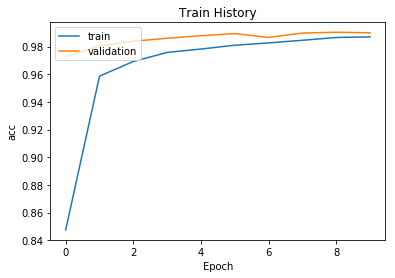

In [11]:
show_train_history(train_history, 'acc', 'val_acc')

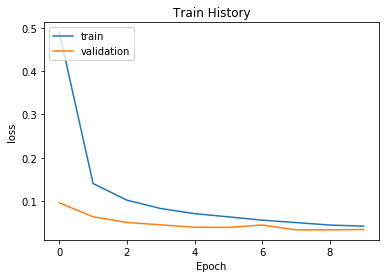

In [12]:
show_train_history(train_history, 'loss', 'val_loss')

## 評估模型準確率與進行預測

我們已經完成訓練, 接下來要使用 test 測試資料集來評估準確率。

### STEP1. 評估模型準確率

In [13]:
scores = model.evaluate(X_Test4D_norm, y_TestOneHot)  
print()  
print("\t[Info] Accuracy of testing data = {:2.1f}%".format(scores[1]*100.0))

10000/10000 [==============================] - 2s 170us/step

	[Info] Accuracy of testing data = 99.1%


### STEP2. 預測結果

In [14]:
print("\t[Info] Making prediction of X_Test4D_norm")  
prediction = model.predict_classes(X_Test4D_norm)  # Making prediction and save result to prediction  
print()  
print("\t[Info] Show 10 prediction result (From 240):")  
print("%s\n" % (prediction[240:250]))

	[Info] Making prediction of X_Test4D_norm

	[Info] Show 10 prediction result (From 240):
[5 9 8 7 2 3 0 4 4 2]



### STEP3. 顯示前 10 筆預測結果

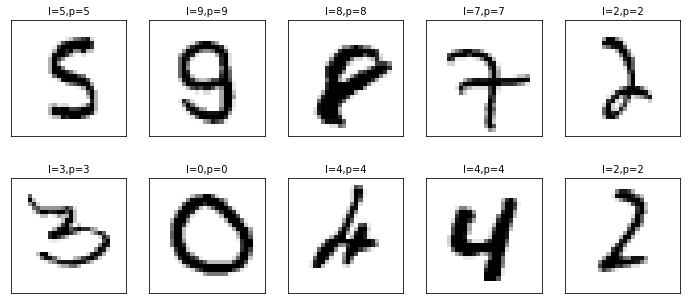

In [15]:
plot_images_labels_predict(X_Test, y_Test, prediction, idx=240)

## 總結 (Conclusion)

在這篇文章中有一些個人學習到的一些有趣的重點:

* Mnist的手寫資料集雖然很簡單, 但對很多不熟悉把圖像處理的人來說, Mnist絕對是一個合適用來做練習與講解的好資料集
* 需要了解網絡的結構與不同網絡層輸入輸出的張量的結構才能夠清楚地構建一個對的模型

參考:
* [程式扎記-Keras - MNIST 手寫數字辨識使用 CNN](http://puremonkey2010.blogspot.tw/2017/06/toolkit-keras-mnist.html)
* [林大貴 - TensorFlow+Keras深度學習人工智慧實務應用](http://tensorflowkeras.blogspot.com)